# Photometric Redshift Regression

## Hubble's Law
The Hubble's Law states that galaxies are moving away from Earth at a speed (recessional velocity) that is proportional to their distance, thus providing a primary evidence for the expansion of the universe. 

**Hubble's Law** is expressed by the following equation: 

$$\large
v = H_0 \times d
$$

* $v$ is the recessional velocity of the galaxy
* $H_0$ is the Hubble constant (or the Hubble parameter at the present time), which represents the universe's current rate of expansion
* $d$ is the the proper distance to the galaxy from the observer (typically measured in megaparsecs, or Mpc)

### Redshift as a proxy 
**Redshift** ($z$) refers to a phenomenon where _the wavelength of light is stretched_, shifting towards the red end of the electromagnetic spectrum. There are three main causes of redshift: 
* **Doppler redshift**: Caused by the relative motion of an object moving away from an observer through space
* **Gravitational redshift**: Occurs when light escapes a strong gravitational field, losing energy as its wavelength is stretched
* **Cosmological redshift**: It is caused by the expansion of space itself as the light travels through the universe. As space expands, the light waves are literally stretched along with it

The redshift parameter is calculated in the following way: 
$$\large
z = \frac {\lambda_{observed}-\lambda_{rest}}{\lambda_{rest}}
$$

* $\lambda_{observed}$ is the wavelength of the light measured by the observer
* $\lambda_{rest}$ is the "known" emitted wavelength of the light

Redshift serves as a direct proxy for distance: a higher redshift means the galaxy is farther away and its light has been traveling (and stretching) for longer. 

The consequence of this is that a closer galaxy might appear brighter in Blue and faint in UV, while a distant galaxy will look bright in Red and faint in Blue. Therefore, a galaxy's "Color Index" changes systematically with distance. This is exactly what we want to confirm here, which can be considered the core/foundation of Hubble's Law: a Galaxy's color is directly related to its distance. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('SDSS_GalaxyData.csv')

## Feature Engineering: Color Indexes

### What is a color index?
A color index is a simple numerical expression for a celestial object's color, which is a _direct indicator of its surface temperature_. It is calculated as the difference between the object's brightness (magnitude) measured through two different standard filters, which isolate specific ranges of the electromagnetic spectrum. 

By convention, the magnitude at the shorter wavelength filter is subtracted from the magnitude at the longer wavelength filter.
Due to the inverse logarithmic nature of the astronomical magnitude scale (where a smaller or more negative number means a brighter object), the interpretation is as follows: 
* **Smaller or negative values**: Indicate a hotter, bluer object, as it is brighter at shorter (bluer/ultraviolet) wavelengths.
* **Larger or positive values**: Indicate a cooler, redder object, as it is brighter at longer (redder/infrared) wavelengths.
* **A value near zero**: For the standard UBV system, a color index of approximately zero indicates a white star with a surface temperature of about 10,000 K, similar to the star Vega. 

Adding the color indices to the `df` dataset. 

In [5]:
# deriving the color indexes
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']

In [6]:
# here are all the columns of the dataframe (including the new ones)
df.columns

Index(['specObjID', 'objID', 'class', 'redshift', 'zWarning', 'velDisp',
       'velDispErr', 'snMedian_r', 'u', 'g', 'r', 'i', 'z', 'err_u', 'err_g',
       'err_r', 'err_i', 'err_z', 'petroR50_r', 'petroR90_r', 'clean',
       'p_el_debiased', 'p_cs_debiased', 'elliptical', 'spiral',
       'h_alpha_flux', 'h_alpha_flux_err', 'h_beta_flux', 'h_beta_flux_err',
       'oiii_5007_flux', 'oiii_5007_flux_err', 'nii_6584_flux',
       'nii_6584_flux_err', 'u-g', 'g-r', 'r-i', 'i-z'],
      dtype='object')

## Machine Learning Preparation
We now import all the specific tools for the ML models that will be used (Random Forest and XGBoost). 

In [7]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import os
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

### Defining a Helper Function
The following function ensures that the metrics are consistent: 
* **MAE (Mean Absolute Error)**: The average absolute value of the error (or residual).
* **RMSE (Root Mean Square Error)**: Similar to MAE, but it penalizes large errors more heavily. This is considered to be the most important metric for a regression model.
* **R² (R-squared)**: The "coefficient of determination." It measures how much of the variance in the true redshift the model can explain.
* **Spearman (rho)**: Checks for monotonic correlation. It answers: "When the true redshift goes up, does the predicted redshift also go up?" (even if not perfectly linear). A value near 1.0 is excellent.

In [8]:
def report_metrics(y_true, y_pred, label=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2   = r2_score(y_true, y_pred)
    rho  = spearmanr(y_true, y_pred).correlation
    print(f"{label:12s}  MAE: {mae:.5f} | RMSE: {rmse:.5f} | R²: {r2:.4f} | Spearman ρ: {rho:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "Spearman": rho}

In [9]:
# removing two observations due to extreme outliers
# which are specObjID 332252930885314560 and 350155723595868160

df = df[~df['specObjID'].isin([332252930885314560, 350155723595868160])]

### Features and Target selection
Now we select exactly the features that we want for the photometric redshift task. Our features are the color indexes that we have computed, while the target variable is the redshift. 

In [10]:
feature_cols = ['u-g','g-r','r-i','i-z']
target_col   = 'redshift'

In [11]:
X = df[feature_cols].copy()
y = df[target_col].values

print("Data shape:", X.shape, "Target shape:", y.shape)

Data shape: (189465, 4) Target shape: (189465,)


**Note**: For each new session, run the code to this point. 

### Redshift distribution

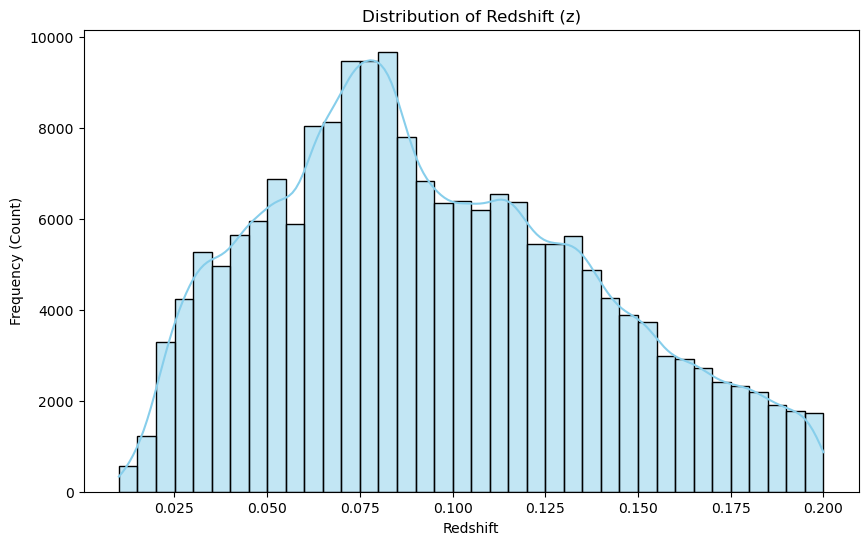

In [12]:
plt.figure(figsize=(10, 6))

sns.histplot(df['redshift'], kde=True, binwidth=0.005, color='skyblue')

plt.title('Distribution of Redshift (z)')
plt.xlabel('Redshift')
plt.ylabel('Frequency (Count)')
plt.show()

### Performing a Stratified Split
As the plot shows, the `redshift` target is not evenly distributed showing a positive skew (there are way more galaxies at low redshift than high redshift), so a simple random split could be "unlucky." We might accidentally get most of the rarer, high-redshift galaxies in the test set, or all in the training set.

**Stratifying** solves this by ensuring the distribution of redshifts in the training set is a perfect reflection of the distribution in the test set. 
In this way, the model will be trained on data that has the same characteristics (redshift distribution) of the data we test it on, making the final metrics a reliable and honest measure of its true performance.

In [13]:
# Stratify by 10-quantile bins to preserve the redshift distribution in both splits
bins = np.quantile(y, q=np.linspace(0, 1, 11)) # 10 quantile bins or deciles (0%, 10%, ..., 100%)

# Remove duplicates in case of repeated quantiles
bins = np.unique(bins)

# this assign a label to each redshift value based on which bin it falls into
y_bins = pd.cut(y, bins=bins, include_lowest=True, duplicates="drop") 

# train and test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y_bins
)

In [ ]:
X_train.shape, X_test.shape

((151572, 4), (37893, 4))

## Split Saver
Saving the split into a .json file guarantees that the data (X_test, y_test) is perfectly aligned with the pre-trained models (rf_best.joblib, xgb_best.joblib).

In [ ]:
SPLIT_FILE = "photz_split.json"
with open(SPLIT_FILE, "w") as f:
    json.dump({
        "feature_cols": list(X.columns),
        "random_state": int(RANDOM_STATE),
        "train_index": X_train.index.tolist(),
        "test_index":  X_test.index.tolist(),
    }, f, indent=2)
print(f"Saved split to {SPLIT_FILE}")


Saved split to photz_split.json


## Color Indexes vs Redshift (Plots)
Let's immediately check the relationship between the selected features (four color indexes) and the target (redshift) through a series of scatter plots. 

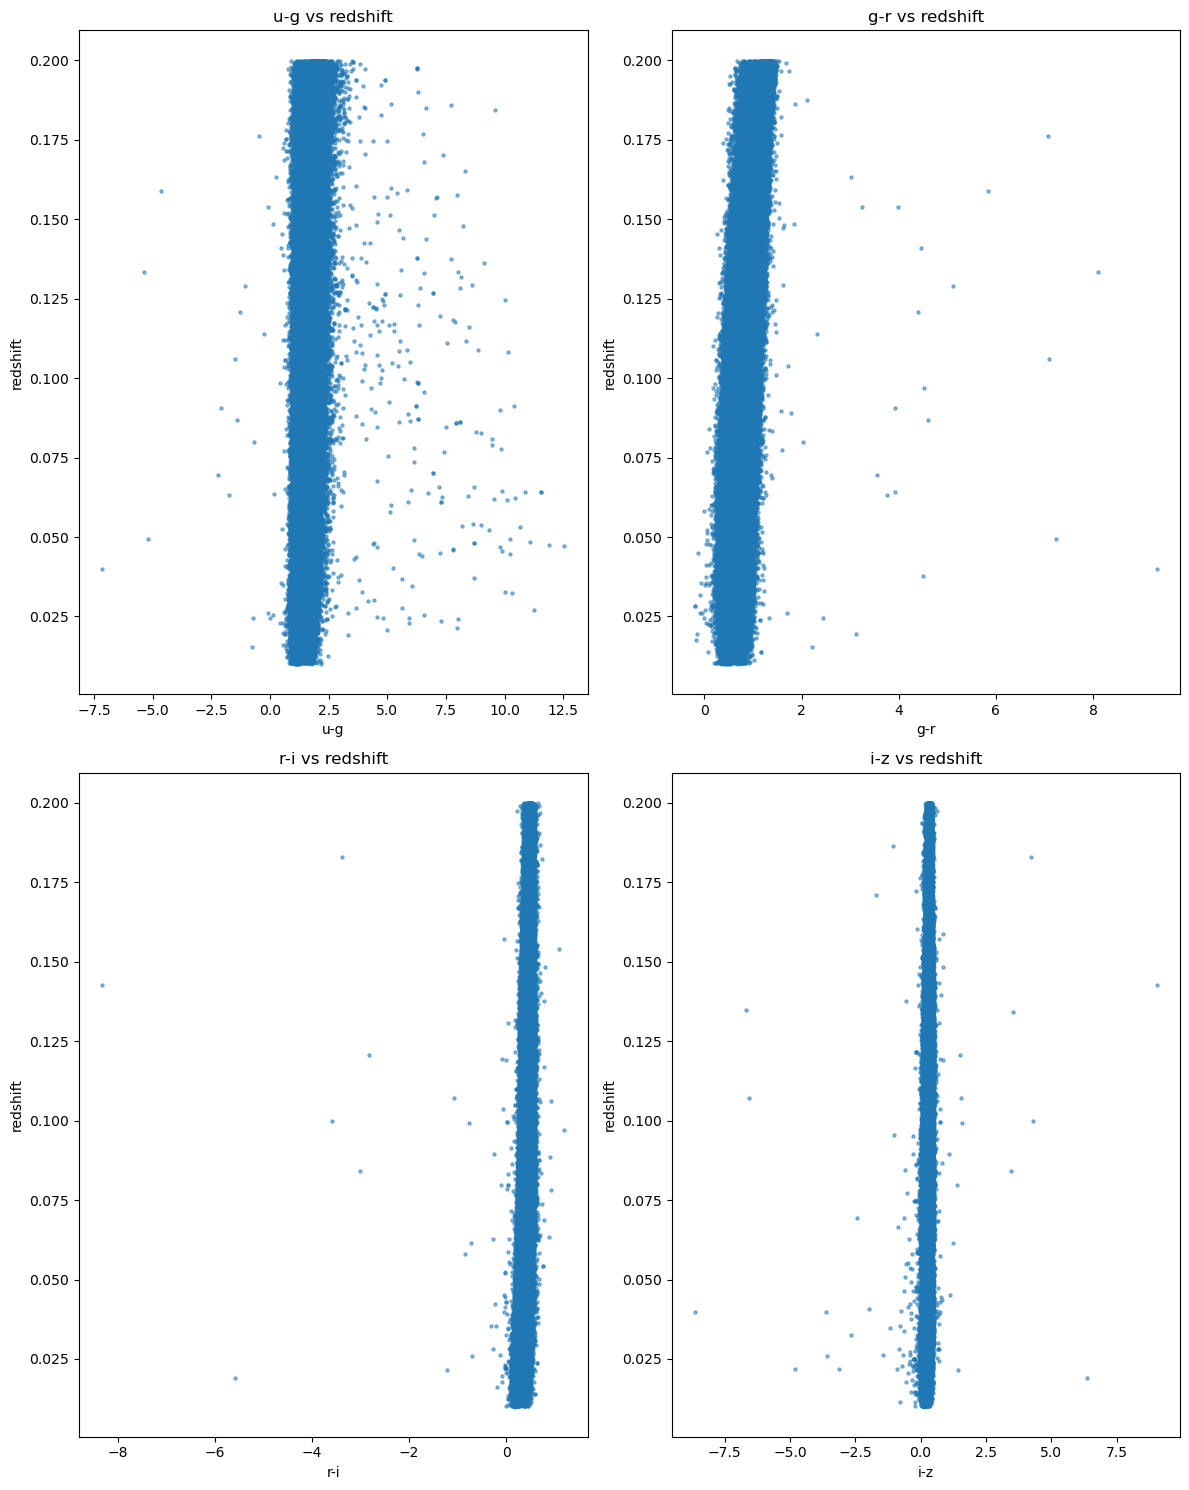

In [14]:
# Create a 2x2 grid of subplots. 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 15))

for i, col in enumerate(feature_cols):
    
    ax = axes.flatten()[i]
    
    ax.scatter(df[col].values, df['redshift'].values, s=5, alpha=0.5)
    
    # Set labels for that axis
    ax.set_xlabel(col)
    ax.set_ylabel("redshift")
    ax.set_title(f"{col} vs redshift")

# This cleans up the spacing so plots don't overlap
plt.tight_layout()

plt.show()

### Analysis of Color vs. Redshift Plots
The initial scatter plots provide a critical insight. The relationship between color and redshift is not uniform across all features:
* No Correlation: The `r-i` and `i-z` plots  show tight, vertical distributions. This indicates that for the redshift range of our data (z≲0.2), these color indices remain nearly constant even as distance changes. This makes them poor predictors on their own.
* Strong Correlation: The `u-g` and `g-r` plots  show wide, slanted clouds. This slant implies a systematic change in color as redshift increases.

### Why does this happen? The 4000 Å (Angstrom) Break
This difference in predictive power is not a statistical fluke, but it is a direct consequence of a physical phenomenon in galaxy spectra known as the **4000 Å (Angstrom) Break**.

A galaxy's spectrum (its light output at all wavelengths) is measured in units Å (Angstrom), which are a way of measuring the light's wavelength (color). 

This spectrum is not smooth. For most galaxies, there is a strong "break" or "cliff-like" discontinuity at 4000 Å (400 nanometers), where the galaxy's light is significantly dimmer on the bluer side (wavelengths <4000 Å) than on the redder side (wavelengths >4000). In other words, when looking from the red side toward the blue side of the spectrum, at the 4000 Å mark, there is a sudden, sharp drop in the brightness of the light, thus the galaxy is much brighter on the red side of 4000 Å than it is on the blue side.

Due to the expansion of the universe (Hubble's Law), light from distant galaxies is "redshifted", thus _the entire spectrum, including the 4000 Å break, is shifted to longer, redder wavelengths_.

In essence, for the specific redshift range of our dataset (z ≲ 0.2), the 4000 Å break is positioned to move between certain filter pairs (like g and r) but not others (like i and z).


#### Why `g-r` seems better than `i-z`?
Since different galaxies have different break strengths (depending on their age, metallicity, and star formation history), the color indices that straddle the break (`u-g` and `g-r` at these redshifts) will exhibit a wide range of values, allowing astronomers to distinguish between different types of galaxies and accurately estimate their photometric redshifts.

For our dataset's redshift range (z≈0 to 0.2), the 4000 Å break is moving directly through these filters. 
* Nearby Galaxy: The break is at a low wavelength, and both the g and r filters measure light on the "red" side of the break.
* Distant Galaxy: The break is redshifted between the g and r filters. The g filter now sees the "dim" blue side of the break, while the r filter still sees the "bright" red side.
* Result: This causes a dramatic change in the g-r color, making it a highly sensitive "meter" for measuring redshift in this specific range.

The i and z filters are "blind" to this process because they are too far in the red/infrared. The 4000 Å break, even when redshifted, does not pass between them. Since the main spectral feature isn't affecting these filters, the `i-z` color remains relatively constant, resulting in a vertical plot and very low feature importance. 


### Comparative Analysis of Color indices vs Redshift
Two color indexes present potential trends that are worth checking through a deeper analysis: g-r, u-g. 

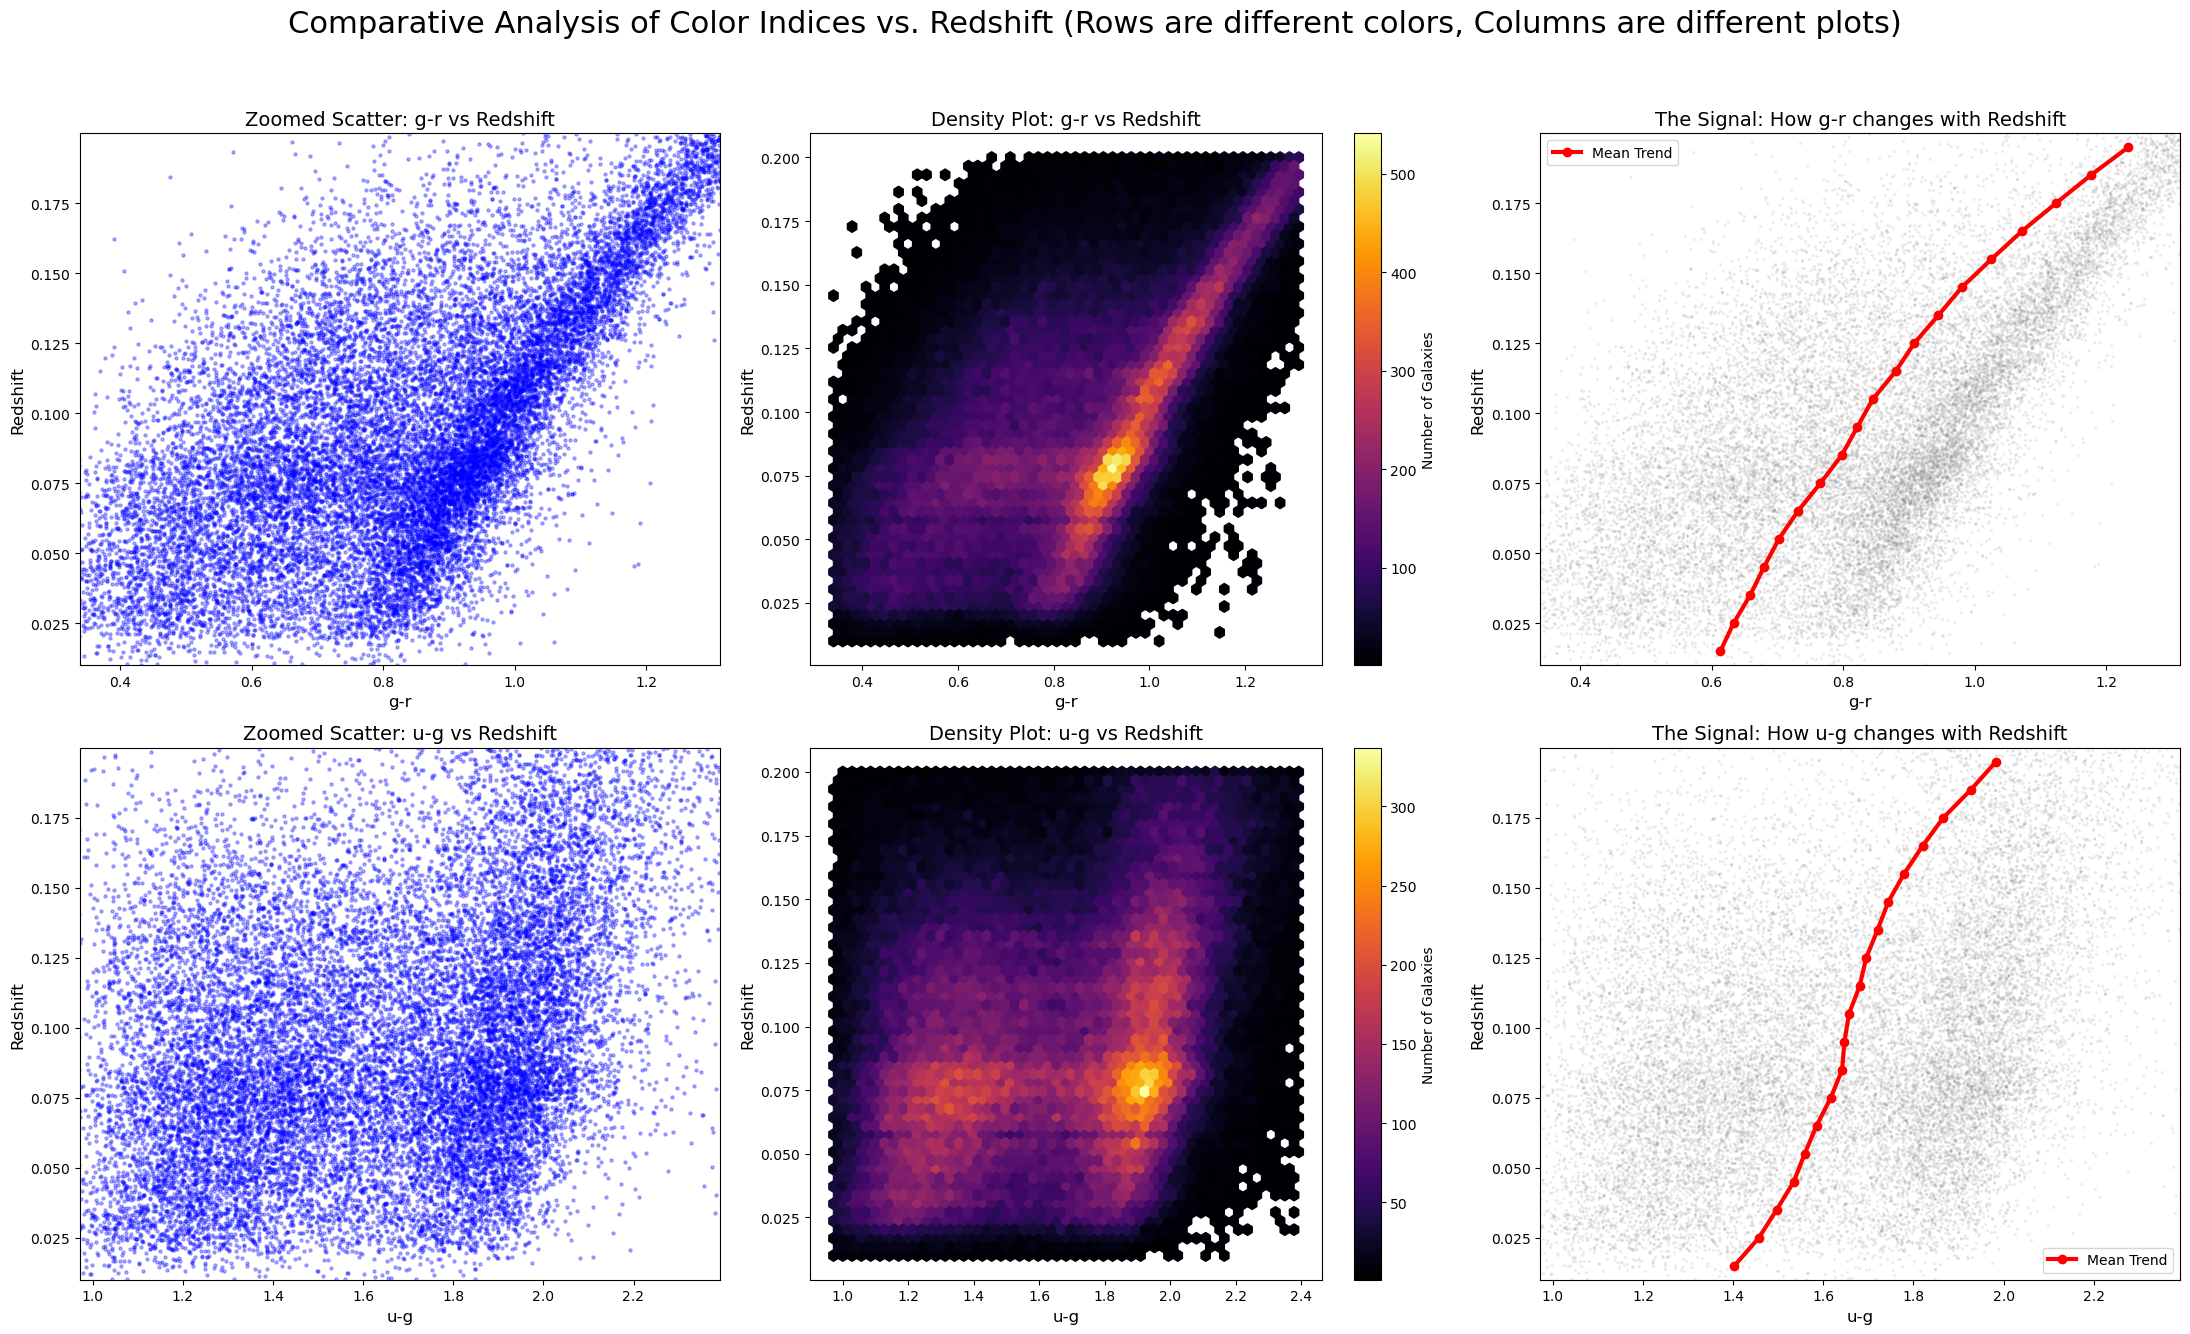

In [15]:

colors_to_plot = ['g-r', 'u-g']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 14))

subset = df.sample(n=20000, random_state=42)

# --- Loop through each color index (for each ROW) ---
for i, col in enumerate(colors_to_plot):
    
    # Calculate reasonable limits (1st and 99th percentile) to ignore extreme outliers
    lower_lim = np.percentile(df[col], 1)
    upper_lim = np.percentile(df[col], 99)
    # Use a consistent redshift limit for all plots
    z_min, z_max = df['redshift'].min(), df['redshift'].max()

    
    # --- Plot 1 (Column 0): The "Zoomed" Scatter Plot ---
    ax = axes[i, 0]
    ax.scatter(subset[col], subset['redshift'], s=5, alpha=0.3, c='blue')
    ax.set_xlim(lower_lim, upper_lim) # Apply the zoom
    ax.set_ylim(z_min, z_max)
    ax.set_title(f'Zoomed Scatter: {col} vs Redshift', fontsize=14)
    ax.set_ylabel('Redshift', fontsize=12)
    ax.set_xlabel(col, fontsize=12)

    
    # --- Plot 2 (Column 1): The Hexbin Density Plot ---
    ax = axes[i, 1]
    # Create the hexbin. Note: extent sets the [xmin, xmax, ymin, ymax]
    im = ax.hexbin(
        df[col], df['redshift'], 
        gridsize=50, 
        cmap='inferno', 
        mincnt=1, # Show bins with at least 1 galaxy
        extent=(lower_lim, upper_lim, z_min, z_max)
    )
    # Add a color bar to show the count scale
    fig.colorbar(im, ax=ax, label='Number of Galaxies')
    ax.set_title(f'Density Plot: {col} vs Redshift', fontsize=14)
    ax.set_ylabel('Redshift', fontsize=12)
    ax.set_xlabel(col, fontsize=12)

    
    # --- Plot 3 (Column 2): The "Binned Mean" Trend ---
    ax = axes[i, 2]
    
    # 1. Create 20 redshift bins
    z_bins = np.linspace(z_min, z_max, 20)
    bin_centers = []
    mean_colors = []
    
    # 2. Calculate the mean color for each redshift bin
    for j in range(len(z_bins)-1):
        mask = (df['redshift'] >= z_bins[j]) & (df['redshift'] < z_bins[j+1])
        if mask.sum() > 20: # Only plot if we have at least 20 data points
            bin_centers.append((z_bins[j] + z_bins[j+1]) / 2)
            mean_colors.append(df.loc[mask, col].mean())
            
    # 3. Plot the faint background cloud for context
    ax.scatter(subset[col], subset['redshift'], s=2, alpha=0.1, color='gray')
    
    # 4. Plot the red TREND LINE (flipping axes to match)
    ax.plot(mean_colors, bin_centers, marker='o', color='red', linewidth=3, label='Mean Trend')
    
    ax.set_xlim(lower_lim, upper_lim) # Apply the same zoom
    ax.set_ylim(z_min, z_max)
    ax.set_title(f'The Signal: How {col} changes with Redshift', fontsize=14)
    ax.set_ylabel('Redshift', fontsize=12)
    ax.set_xlabel(col, fontsize=12)
    ax.legend()

# Add a single, overarching title for the entire figure
fig.suptitle('Comparative Analysis of Color Indices vs. Redshift (Rows are different colors, Columns are different plots)', fontsize=22)
# Adjust layout to prevent plots from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Galaxy Bimodality
These plots reveal a fundamental pattern. 
The trend in `g-r` appears as a single, clear, curved path. However, the `u-g` plot clearly looks "bimodal," as if two distinct patterns are happening at once.

This isn't random. Our dataset doesn't contain just a uniform cloud of galaxies, instead different families of galaxies are present.
These plots are visually proving the **Galaxy Bimodality**: the fact that galaxies in the universe naturally fall into two distinct populations:
* **The "Red Sequence"**: This is the tight, dense group you see. These are the Elliptical galaxies—old, massive, "red and dead" galaxies that are no longer forming stars. They have very little blue or ultraviolet (u) light, so they cluster together at high u-g and u-r values.

* **The "Blue Cloud"**: This is the messier, more diffuse group (the "second trend"). These are the Spiral galaxies—young, star-forming galaxies (like our Milky Way). They are full of hot, young, blue stars, so they are very bright in the u filter, giving them completely different u-g colors.

* **The "Green Valley"**: The sparse region between these two peaks contains galaxies that are in a transition phase, likely on their way from the blue cloud to the red sequence as their star formation shuts down.

The plot for `u-g` shows this split most dramatically because the `u` (ultraviolet) filter is the single best detector of star formation. Hot, young, massive stars (found in spirals) pour out ultraviolet light, making them extremely bright in the `u` bucket. 
Old, "dead" stars (found in ellipticals) emit almost none. This creates the massive color gap we see in these two plots, which are effectively separating the "living" galaxies from the "dead" ones.

In short, this plot is a visual confirmation that the two main types of galaxies, Spirals and Ellipticals, live in two completely different "clouds" on a color diagram.

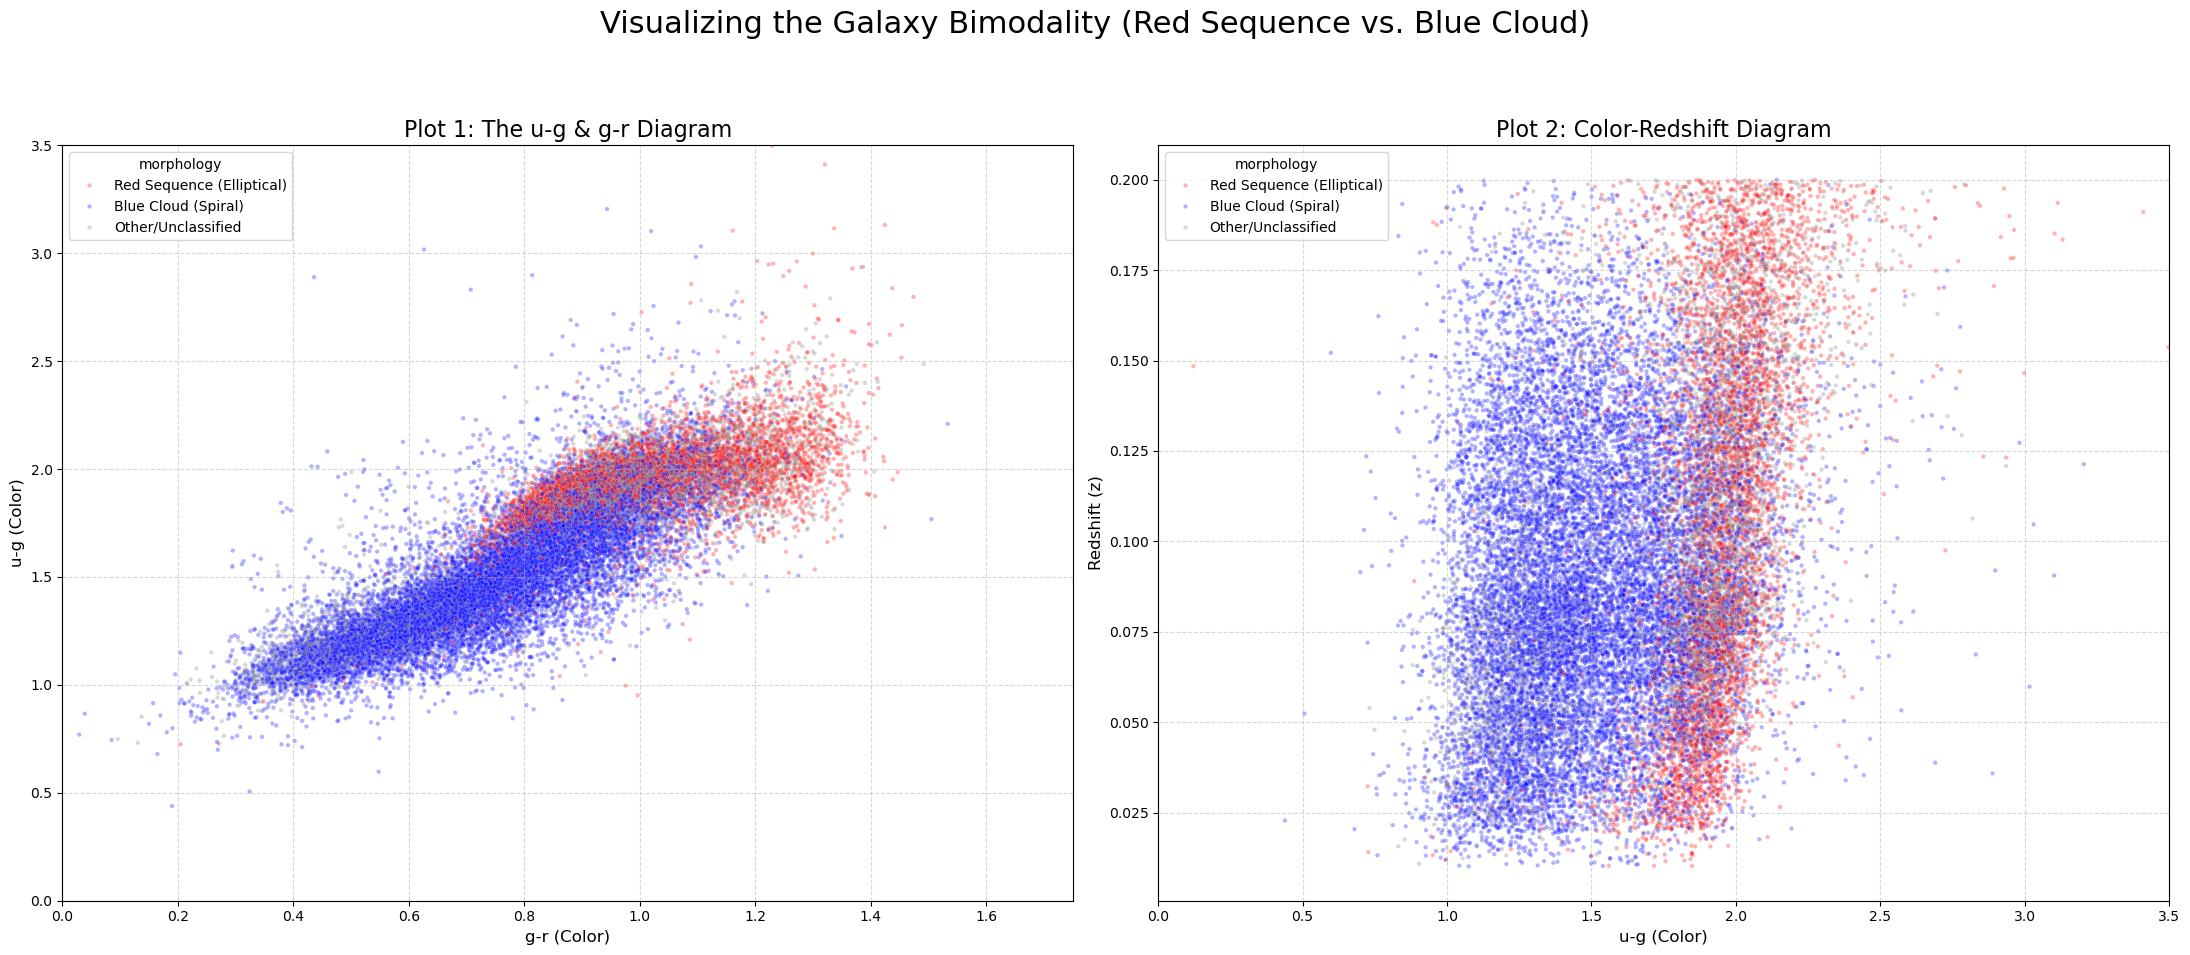

In [16]:
# 1. Create a new 'morphology' column for easier plotting
# We classify galaxies into three groups for clarity

# Make a copy to avoid SettingWithCopyWarning
df_plot = df.copy()

def get_morphology(row):
    if row['elliptical'] == 1:
        return 'Red Sequence (Elliptical)'
    elif row['spiral'] == 1:
        return 'Blue Cloud (Spiral)'
    else:
        return 'Other/Unclassified'

df_plot['morphology'] = df_plot.apply(get_morphology, axis=1)

# 2. Create a sample for plotting
# Plotting all 189k points is too slow and messy (overplotting)
# A sample of 25,000 is statistically representative and clear
n_sample = 25000
if len(df_plot) > n_sample:
    df_sample = df_plot.sample(n=n_sample, random_state=42)
else:
    df_sample = df_plot

# 3. Create the 1x2 plot dashboard
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
fig.suptitle('Visualizing the Galaxy Bimodality (Red Sequence vs. Blue Cloud)', fontsize=22)

# --- Plot 1: The "Classic" Color-Color Plot (g-r vs u-g) ---
ax0 = axes[0]
sns.scatterplot(
    data=df_sample,
    x='g-r',
    y='u-g',
    hue='morphology',
    palette={'Red Sequence (Elliptical)': 'red', 'Blue Cloud (Spiral)': 'blue', 'Other/Unclassified': 'grey'},
    hue_order=['Red Sequence (Elliptical)', 'Blue Cloud (Spiral)', 'Other/Unclassified'],
    s=10,
    alpha=0.3,
    ax=ax0
)
ax0.set_title('Plot 1: The u-g & g-r Diagram', fontsize=16)
ax0.set_xlabel('g-r (Color)', fontsize=12)
ax0.set_ylabel('u-g (Color)', fontsize=12)
ax0.set_xlim(0, 1.75)  # Zoom in on the main clumps
ax0.set_ylim(0, 3.5)  # Zoom in on the main clumps
ax0.grid(True, linestyle='--', alpha=0.5)

# --- Plot 2: The Color-Redshift Plot (u-g vs z) ---
ax1 = axes[1]
sns.scatterplot(
    data=df_sample,
    x='u-g',
    y='redshift',
    hue='morphology',
    palette={'Red Sequence (Elliptical)': 'red', 'Blue Cloud (Spiral)': 'blue', 'Other/Unclassified': 'grey'},
    hue_order=['Red Sequence (Elliptical)', 'Blue Cloud (Spiral)', 'Other/Unclassified'],
    s=10,
    alpha=0.3,
    ax=ax1
)
ax1.set_title('Plot 2: Color-Redshift Diagram', fontsize=16)
ax1.set_xlabel('u-g (Color)', fontsize=12)
ax1.set_ylabel('Redshift (z)', fontsize=12)
ax1.set_xlim(0, 3.5) # Zoom in on the main clumps
ax1.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust for main title
plt.show()

# Random Forest
We first do a KFold Cross Validation (5 folds) and then proceed to define a base Random Forest model.
Once defined a search space, we can use the `RandomizedSearchCV`, a tuner that will only pick a number of combinations from the `rf_space` menu equal to `n_iter` and test them. This saves a lot of time. 

Eventually, we run a sort of diagnostic (`rf_best.feature_importances_`) and ask the best Random Forest model what features it found to be the most useful for making predictions.
We get a list of scores (adding up to 1.0) that rate how important each feature was.


In [21]:
# 5-fold CV
cv_rf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Defining the base model
rf_model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1) 

# Compact search space for Randomized Search
rf_space = {
    "n_estimators":      [100, 250, 500],     # number of trees
    "max_depth":         [8, 12, 20],         # tree depth
    "min_samples_split": [2, 5],              # split regularization
    "min_samples_leaf":  [1, 2],              # leaf regularization
    "max_features":      ["sqrt", 0.7],       # feature subsampling
    "bootstrap":         [True],
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_space,
    n_iter=4,                                   
    cv=cv_rf,
    scoring="neg_root_mean_squared_error",      # for the comparison we use the highest Negative RMSE
    random_state=RANDOM_STATE,
    n_jobs=-1,                                  
    verbose=2                                   # show per-fit progress
)

print("Starting RF search...")
rf_search.fit(X_train, y_train)                     # start of the search

print("\nBest RF params:", rf_search.best_params_)  # prints the dictionary of settings for the single best-performing model
rf_best = rf_search.best_estimator_                 # extract the best model itself

# Evaluate on the hold-out test set
rf_pred = rf_best.predict(X_test)                               # final test on unseen data
rf_metrics = report_metrics(y_test, rf_pred, "RandomForest")    # final report 

# Quick look at feature importances
importances = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nRF feature importances:\n", importances)

Starting RF search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, max_depth=8, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  36.0s
[CV] END bootstrap=True, max_depth=8, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators

In [42]:
joblib.dump(rf_best, "rf_best.joblib")                                      # contains the fully trained Random Forest model object
json.dump(rf_metrics, open("rf_metrics.json","w"), indent=2)                # saves the metrics, which is just a dictionary, into a json file
json.dump(rf_search.best_params_,open("rf_best_param.json","w"), indent=2)  # saves the best parameters of the random forest

## Random Forest: model results
Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 20, 'bootstrap': True}
RandomForest  MAE: 0.01517 | RMSE: 0.02063 | R²: 0.7766 | Spearman ρ: 0.8574

RF feature importances:
* g-r    0.524680
* r-i    0.200012
* u-g    0.165146
* i-z    0.110162


# XGBoost
For the CV, the same seed, shuffle and KFold are used so the comparison between XGBoost and Random Forest is perfectly fair. 
Then a base XGBoost model is defined.  

In [22]:
# 5-fold KFold CV
cv_xgb = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Base XGBoost model
xgb_model = XGBRegressor(
    random_state=RANDOM_STATE,
    objective="reg:squarederror",             # the objective is regression, measure the error by squaring it
    tree_method="hist",
    n_jobs=-1,
    eval_metric="rmse"
)

# Search space of parameters
xgb_space = {
    "n_estimators":        [100, 300, 500, 700],     # boosting rounds
    "max_depth":           [4, 6, 8, 10],            # depth controls complexity
    "learning_rate":       [0.05, 0.10],             # smaller LR needs more trees
    "subsample":           [0.8, 1.0],               # row subsampling for regularization
    "colsample_bytree":    [0.8, 1.0],               # column subsampling for regularization
    "reg_lambda":          [0.0, 1.0, 2.0],          # L2 regularization
    "min_child_weight":    [1, 5],                   # leaf minimum Hessian sum analog; higher = simpler
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_space,
    n_iter=10,                                 
    cv=cv_xgb,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

print("Starting XGB search...")
xgb_search.fit(X_train, y_train)              # training process starts

print("\nBest XGB params:", xgb_search.best_params_)
xgb_best = xgb_search.best_estimator_

# Evaluate on the hold-out test set
xgb_pred = xgb_best.predict(X_test)
xgb_metrics = report_metrics(y_test, xgb_pred, "XGBoost")

# Quick look at feature importances
importances = pd.Series(xgb_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nXGB feature importances:\n", importances)


Starting XGB search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=700, reg_lambda=1.0, subsample=0.8; total time=  10.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=700, reg_lambda=1.0, subsample=0.8; total time=  10.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=700, reg_lambda=1.0, subsample=0.8; total time=  10.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=700, reg_lambda=1.0, subsample=0.8; total time=  10.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=700, reg_lambda=1.0, subsample=0.8; total time=  10.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100, reg_lambda=0.0, subsample=0.8; total time=   1.9s
[CV] END c

In [43]:
joblib.dump(xgb_best, "xgb_best.joblib")                                        # saves the fully trained XGBoost model
json.dump(xgb_metrics, open("xgb_metrics.json","w"), indent=2)                  # saves the final scores/metrics
json.dump(xgb_search.best_params_, open("xgb_best_param.json","w"), indent=2)   # saves the best parameters of xgb

## XGBoost: model results
Best XGB params: {'subsample': 1.0, 'reg_lambda': 2.0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
XGBoost       MAE: 0.01559 | RMSE: 0.02103 | R²: 0.7680 | Spearman ρ: 0.8520

XGB feature importances:
* g-r    0.687299
* u-g    0.140737
* r-i    0.113505
* i-z    0.058460

# Linear Regression

## Assumptions of Linear Regression
Before we can trust the results of a Linear Regression, we must check that its underlying assumptions are met. If we violate these assumptions, our model's results will be unreliable, unstable, and misleading.

There are four main assumptions (often remembered by the acronym "LINE"):
* L - **Linearity**: The relationship between the features ($X$) and the target ($y$) must be linear. If the true relationship is curved (non-linear), the model will be a poor fit.

* I - **Independence**: The observations must be independent of each other. (This is guaranteed by the random nature of our data collection).

* N - **Normality**: The residuals (the errors) must be approximately normally distributed (i.e., a "bell curve") centered at zero.

* E - **Homoscedasticity**: The residuals must have constant variance at all levels of the predictors. This means the "spread" of the errors should be the same for low and high predicted values (i.e., no "fanning" shape).

A fifth, critical assumption for interpreting the model's coefficients is the Absence of high Multicollinearity.

* **Multicollinearity**: This occurs when features are highly correlated with each other. This makes it impossible for the model to know which feature "deserves" the credit, leading to unstable and nonsensical coefficients.

Let's test these assumptions on the data.

In [16]:
lin_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  LinearRegression())
])
lin_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [17]:
def binned_curve(y_true, y_pred, n_bins=20):
    """Calculates the mean of y_true and y_pred in bins of y_true."""
    edges = np.quantile(y_true, np.linspace(0, 1, n_bins+1))
    edges = np.unique(edges)
    idx = np.digitize(y_true, edges[1:-1])
    
    t_mean, p_mean = [], []
    for b in range(len(edges)-1):
        m = (idx == b)
        if m.sum() > 0:
            t_mean.append(y_true[m].mean())
            p_mean.append(y_pred[m].mean())
    return np.array(t_mean), np.array(p_mean)

#### Linearity, Homoscedasticity and Normality of residuals

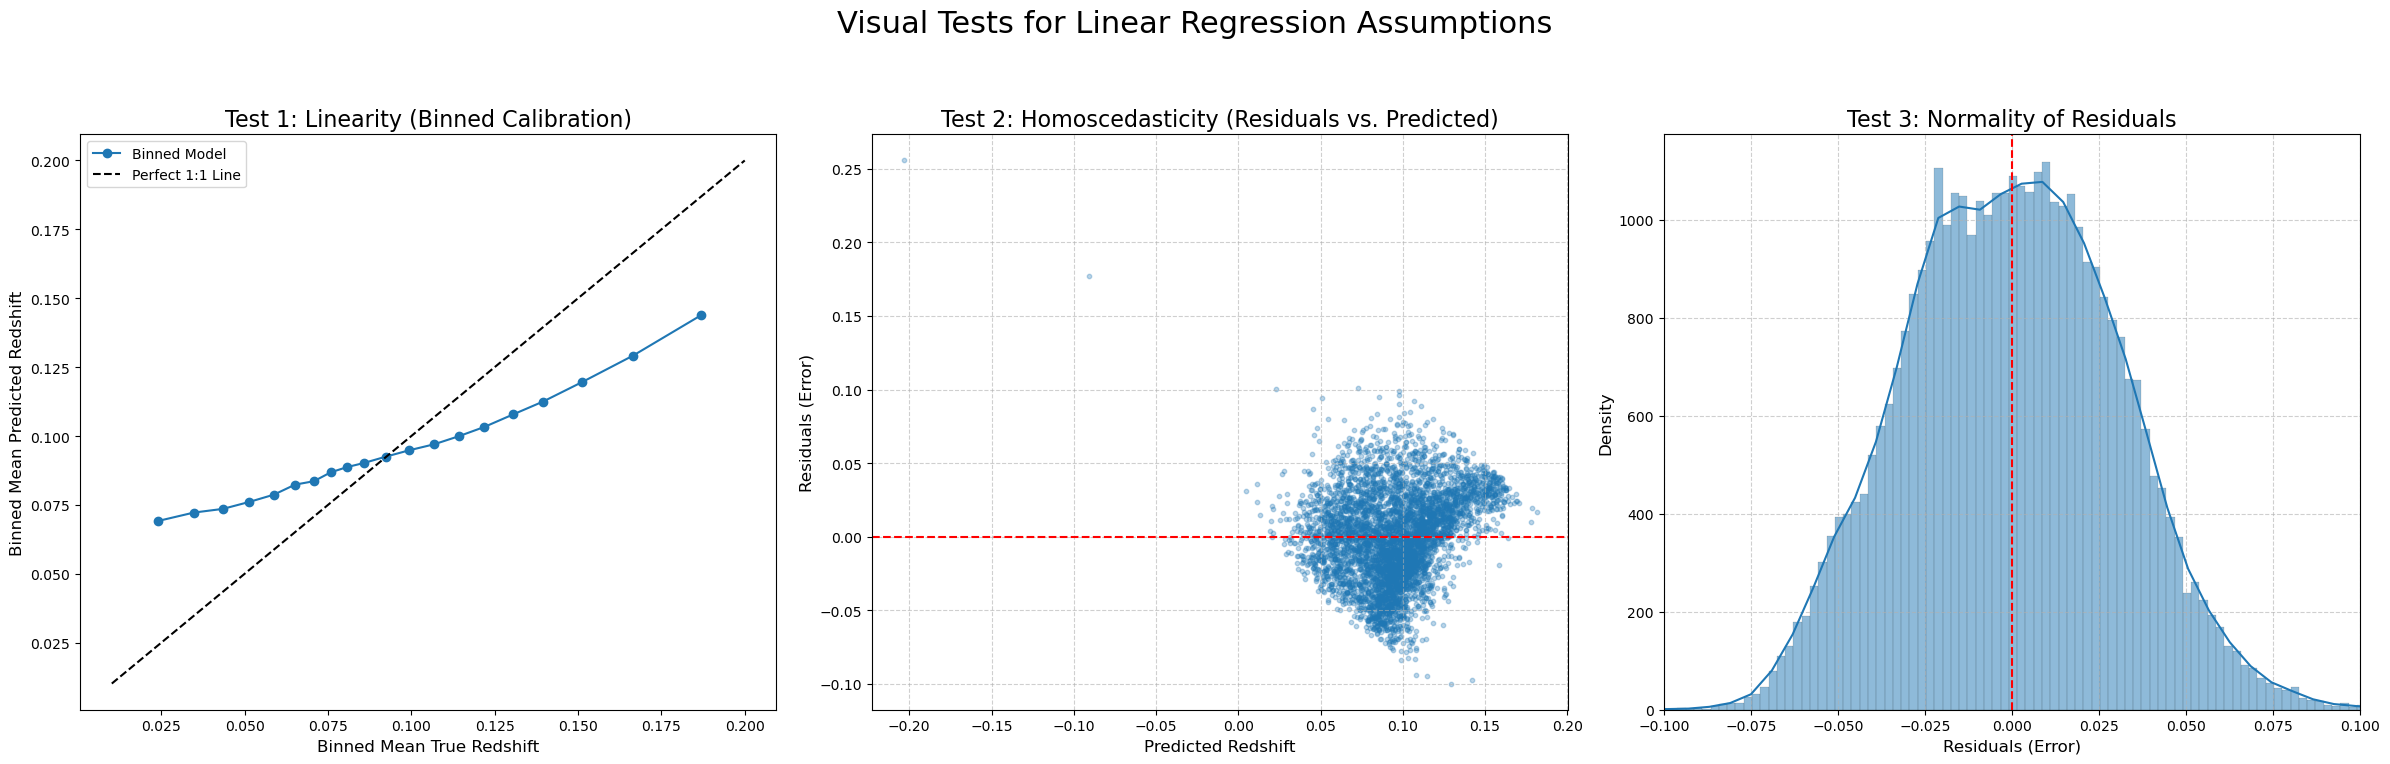

In [18]:
# 1. Get Predictions and Residuals
lin_pred = lin_pipe.predict(X_test)
residuals = y_test - lin_pred

# 2. Create the 1x3 plot dashboard
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
fig.suptitle('Visual Tests for Linear Regression Assumptions', fontsize=22)

# --- Plot 1: Linearity (Predicted vs. True) ---
ax0 = axes[0]
# We can use the 'binned_curve' function from the comparison dashboard (from Photometric Redshift Model comparison)
# (I also put it in the cell before for safety).
t_mean, p_mean = binned_curve(y_test, lin_pred, n_bins=20)
ax0.plot(t_mean, p_mean, marker='o', label='Binned Model', color='C0')
lo, hi = y_test.min(), y_test.max()
ax0.plot([lo, hi], [lo, hi], 'k--', label='Perfect 1:1 Line')
ax0.set_title('Test 1: Linearity (Binned Calibration)', fontsize=16)
ax0.set_xlabel('Binned Mean True Redshift', fontsize=12)
ax0.set_ylabel('Binned Mean Predicted Redshift', fontsize=12)
ax0.legend()

# --- Plot 2: Homoscedasticity (Predicted vs. Residuals) ---
ax1 = axes[1]
# Use a sample for the scatter to avoid overplotting
sample_indices = np.random.choice(residuals.size, 5000, replace=False)
ax1.scatter(lin_pred[sample_indices], residuals[sample_indices], s=10, alpha=0.3)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title('Test 2: Homoscedasticity (Residuals vs. Predicted)', fontsize=16)
ax1.set_xlabel('Predicted Redshift', fontsize=12)
ax1.set_ylabel('Residuals (Error)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Plot 3: Normality (Histogram of Residuals) ---
ax2 = axes[2]
sns.histplot(residuals, kde=True, ax=ax2, bins=500)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_title('Test 3: Normality of Residuals', fontsize=16)
ax2.set_xlabel('Residuals (Error)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_xlim(-0.1, 0.1) # Zoom in on the main peak
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

Interpretation:
* Plot 1 (Linearity): If the blue dots curve away from the dashed 1-to-1 line, the linearity assumption is violated.

* Plot 2 (Homoscedasticity): If the plot shows a 'fanning' or 'cone' shape (not a random cloud), the homoscedasticity assumption is violated. 

* Plot 3 (Normality): If the histogram is not a perfect bell curve (e.g., it's skewed or has fat tails), the normality assumption is violated.

In our case the Linearity and Homoscedasticity assumptions are definitely VIOLATED. 

#### Multicollinearity Test

To check if the independent variables (predictors) are highly correlated with each other, we use the VIF test. 

**VIF** (Variance Inflation Factor) measures how much a feature is explained by other features:
* VIF = 1: Not correlated.

* VIF > 5: High correlation, potentially problematic.

* VIF > 10: Very high correlation. Coefficients and p-values are unreliable.

* VIF = inf (infinity): Perfect multicollinearity. The model is unstable.

In [19]:
# 1. Get the 'scaler' from the trained pipeline
# We must test VIF on the same (scaled) data the model 'sees'
scaler = lin_pipe.named_steps['scaler']

# 2. Scale the X_train data
X_train_scaled = scaler.transform(X_train)

# 3. Create a DataFrame with column names (required by statsmodels)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)

# 4. Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled_df.columns

# Calculate VIF, handling potential 'inf' values from perfect multicollinearity
vif_values = []
for i in range(X_train_scaled_df.shape[1]):
    try:
        vif = variance_inflation_factor(X_train_scaled_df.values, i)
    except np.linalg.LinAlgError:
        vif = np.inf  # Set to infinity if matrix is singular
    vif_values.append(vif)
    
vif_data["VIF"] = vif_values

print(vif_data.sort_values(by="VIF", ascending=False))

  Feature       VIF
1     g-r  3.653789
2     r-i  2.268586
0     u-g  2.130556
3     i-z  1.809218


## LR: model results

In [20]:
# Metrics for Linear Regression
lin_metrics = report_metrics(y_test, lin_pred, "LinearReg_Scaled")

scaler = lin_pipe.named_steps['scaler']
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

# Use a DataFrame so statsmodels shows feature names (e.g., 'u-r', 'g-r', ...)
feat_names = list(X_train.columns)
Xtr_s_df = pd.DataFrame(Xtr_s, columns=feat_names, index=X_train.index)

# Add intercept explicitly so the summary shows "const"
Xtr_sm = sm.add_constant(Xtr_s_df, has_constant='add')

# Fit OLS and print full summary
ols = sm.OLS(y_train, Xtr_sm).fit()
print("\n=== OLS summary on SCALED features (matches pipeline preprocessing) ===")
print(ols.summary())

LinearReg_Scaled  MAE: 0.02484 | RMSE: 0.03118 | R²: 0.4899 | Spearman ρ: 0.7031

=== OLS summary on SCALED features (matches pipeline preprocessing) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 2.884e+04
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:27:36   Log-Likelihood:             3.0216e+05
No. Observations:              151572   AIC:                        -6.043e+05
Df Residuals:                  151567   BIC:                        -6.043e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

This first summary, "OLS summary on SCALED features," is the standard report. It operates on the critical assumption that our model's errors are "homoscedastic", so the errors should be randomly and evenly spread out.

However, our "Test 2: Homoscedasticity" plot clearly violates this assumption. In fact, we see a "fanning" or "cone" shape, which proves our model's errors get larger as the predicted redshift increases (so we actually have ***heteroscedasticity***). When this assumption is broken, the p-values and standard errors in this first summary are unreliable and cannot be trusted.

In [21]:

# Robust (HC3) standard errors version — same coefficients, robust SE/t/p
ols_hc3 = ols.get_robustcov_results(cov_type='HC3')
print("\n=== OLS summary with HC3-robust standard errors ===")
print(ols_hc3.summary())


=== OLS summary with HC3-robust standard errors ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     2971.
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:27:38   Log-Likelihood:             3.0216e+05
No. Observations:              151572   AIC:                        -6.043e+05
Df Residuals:                  151567   BIC:                        -6.043e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

This second summary, "OLS summary with HC3-robust standard errors," is Heteroscedasticity-Consistent and it is a statistical correction that recalculates the p-values to be accurate even when heteroscedasticity is present. 

This is the summary we must use for our final analysis.

Looking at the HC3 summary we see a relevant change:
* The p-values for r-i (0.286) and i-z (0.123) are now very high (much greater than 0.05). 

* Once we correct for the fanning errors, we can see that r-i and i-z are not statistically significant predictors. This confirms our initial visual intuition from the scatter plots: the vertical, "no-signal" color indices are indeed not useful for a linear model.

* The only features with real predictive power are u-g and g-r.

In [22]:
# Back-transform coefficients to ORIGINAL feature units for interpretability
#    y = a_std + Σ b_std * ((x - μ)/σ)  ⇒  y = a_un + Σ b_un * x
#    where b_un = b_std / σ,  a_un = a_std - Σ (b_std * μ / σ)
mu    = scaler.mean_
sigma = scaler.scale_
b_std = pd.Series(ols.params[feat_names].values, index=feat_names)
a_std = float(ols.params['const'])

b_un = b_std / sigma
a_un = a_std - np.sum(b_std.values * mu / sigma)

coef_unscaled = pd.DataFrame({
    "term": ["const"] + feat_names,
    "coef_unscaled": np.r_[a_un, b_un.values]
})
print("\nCoefficients back in ORIGINAL feature units:")
print(coef_unscaled.to_string(index=False))


Coefficients back in ORIGINAL feature units:
 term  coef_unscaled
const       0.019419
  u-g      -0.033248
  g-r       0.162615
  r-i       0.031544
  i-z      -0.059814


Now we can look at the Coefficients back in their original feature units and focus only on the two statistically significant features identified by the HC3 summary:
* g-r: 0.162615. 
  * This is the strongest, most significant linear driver. The positive coefficient confirms our main physical rule: for every 1-magnitude increase in a galaxy's g-r color (it gets redder), the model predicts a +0.163 increase in redshift. This "main rule" works perfectly for the majority of "Red Sequence" (old, elliptical) galaxies.

* u-g: -0.033248.
  * This is where the model gets clever. This negative coefficient acts as a sort of _Correction Rule_ to handle the Galaxy Bimodality we observed earlier.

The model, in fact, has to face a problem: a distant "Blue Cloud" (spiral) galaxy is naturally blue, but it can be redshifted so much that its g-r color looks the same as a nearby "Red Sequence" (elliptical) galaxy. 

**How can the model tell the two galaxies apart?**

It uses u-g as a corrector. A low u-g value means that we are observing a Blue Cloud galaxy, full of young, hot stars and it's probably farther away than its g-r color makes it look. 

The negative coefficient is the mathematical tool for this correction. When the model sees a "Blue Cloud" galaxy (with a low u-g value), it subtracts a smaller number from its prediction. By subtracting less, it correctly boosts the final redshift estimate, compensating for the galaxy's natural blueness.

This entire analysis confirms that our trained Random Forest and XGBoost were correct to focus on `g-r` and `u-g` as the most important features. While, the Linear Regression's low overall $R^2$ score (0.49), combined with its clear violations of linearity and homoscedasticity, proves that a simple linear model is not powerful enough to capture the true, complex, non-linear relationship between galaxy color and distance. 

# Retrieving info from memory

In [24]:
with open("rf_metrics.json", "r") as f:
    rf_metrics = json.load(f)
print("Successfully loaded Random Forest *metrics*.")

with open("xgb_metrics.json", "r") as f:
    xgb_metrics = json.load(f)
    print("Successfully loaded XGBoost *metrics*.")

Successfully loaded Random Forest *metrics*.
Successfully loaded XGBoost *metrics*.


# Models Comparison

In [25]:
# Comparison Table
rows = []
rows.append(("Linear Regression_Scaled", lin_metrics["MAE"], lin_metrics["RMSE"], lin_metrics["R2"], lin_metrics["Spearman"]))
rows.append(("Random Forest", rf_metrics["MAE"], rf_metrics["RMSE"], rf_metrics["R2"], rf_metrics["Spearman"]))
rows.append(("XGBoost", xgb_metrics["MAE"], xgb_metrics["RMSE"], xgb_metrics["R2"], xgb_metrics["Spearman"]))
comparison_df = pd.DataFrame(rows, columns=["Model", "MAE", "RMSE", "R2", "Spearman"]).sort_values("RMSE")

# Sort by RMSE to see the best out of all three
print("\nFinal Model Comparison (Sorted by RMSE)")
display(comparison_df.style.format({"MAE":"{:.5f}","RMSE":"{:.5f}","R2":"{:.4f}","Spearman":"{:.4f}"}))


Final Model Comparison (Sorted by RMSE)


# Picking the Best Model
It's now time to select the best trained model out of the three by comparing the RMSE. 

In [26]:
print("--- Finding the Best Overall Model ---")

rf_rmse = rf_metrics["RMSE"]
xgb_rmse = xgb_metrics["RMSE"]
lin_rmse = lin_metrics["RMSE"]

if rf_rmse <= xgb_rmse and rf_rmse <= lin_rmse:
    best_name = "RandomForest"
    best_model = rf_best
elif xgb_rmse <= rf_rmse and xgb_rmse <= lin_rmse:
    best_name = "XGBoost"
    best_model = xgb_best
else:
    best_name = "LinearReg_Scaled"
    best_model = lin_pipe 

print(f"The best overall model (lowest RMSE) is: {best_name}")
print(f"Winner's RMSE: {min(rf_rmse, xgb_rmse, lin_rmse):.5f}")

--- Finding the Best Overall Model ---
The best overall model (lowest RMSE) is: RandomForest
Winner's RMSE: 0.02063


## Photometric Redshift Model comparison Dashboard

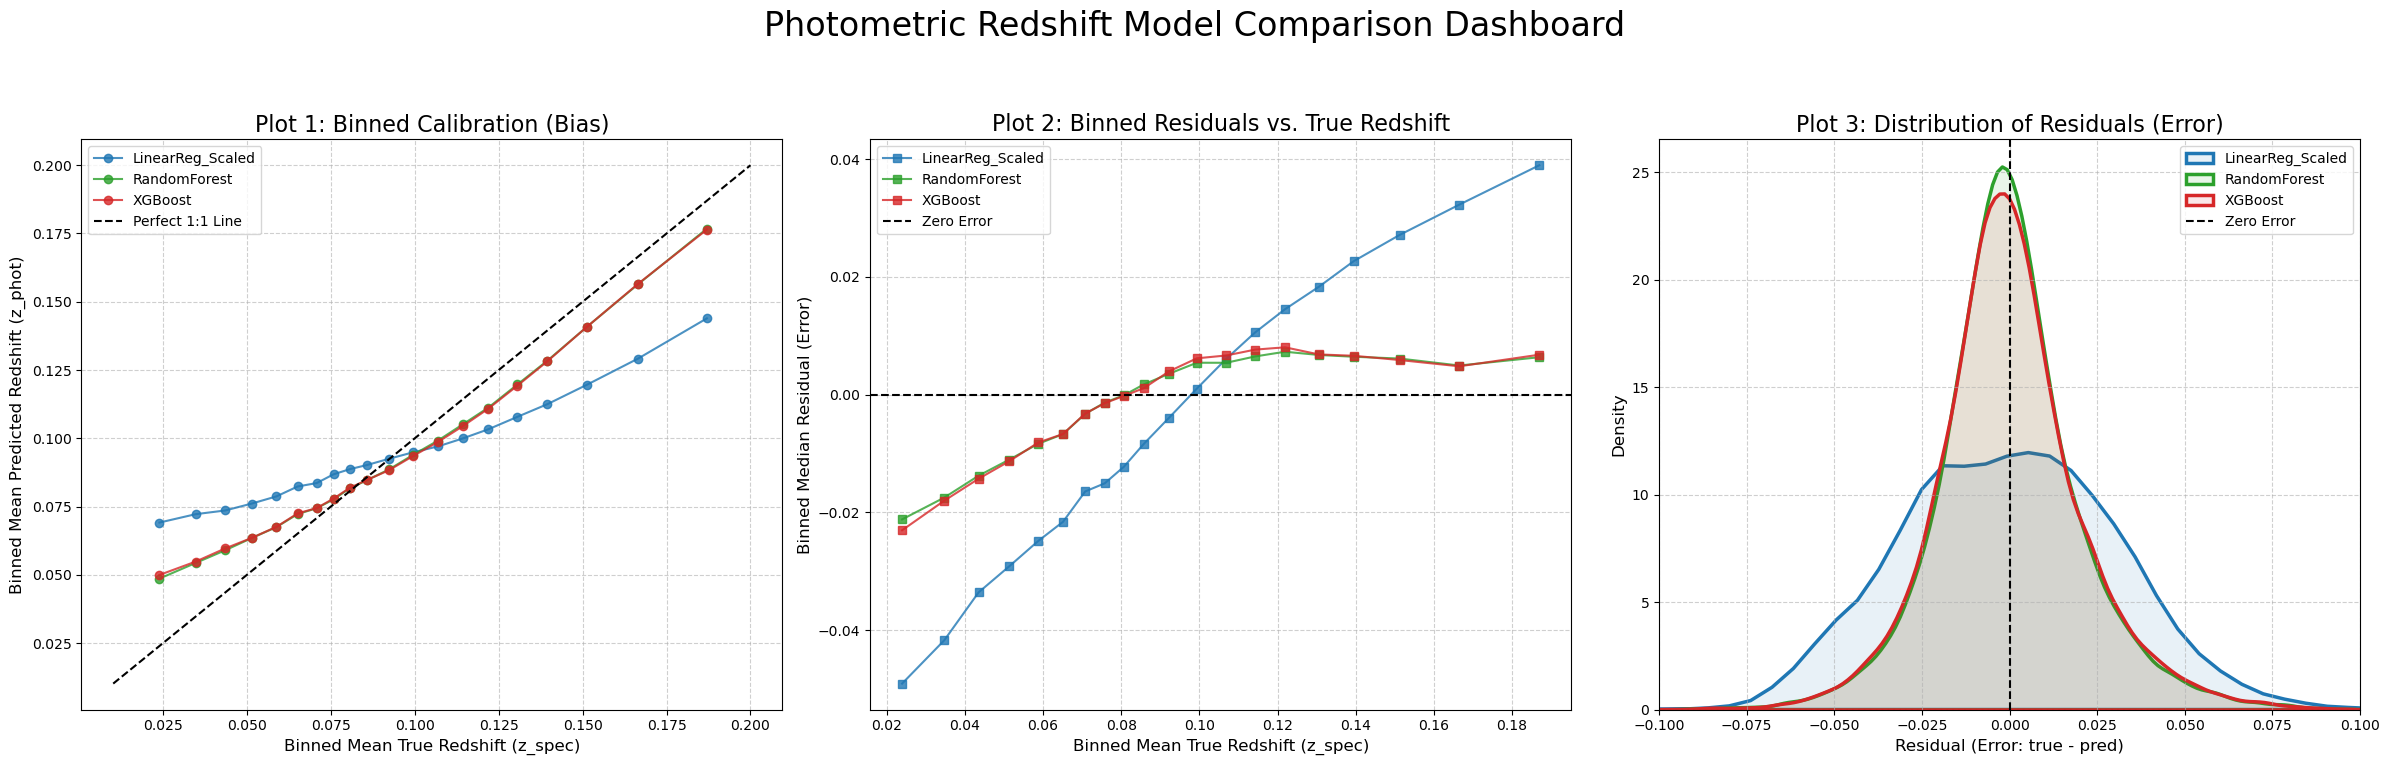

In [ ]:

# Helper Functions for Binning
def binned_curve(y_true, y_pred, n_bins=20):
    """Calculates the mean of y_true and y_pred in bins of y_true."""
    edges = np.quantile(y_true, np.linspace(0, 1, n_bins+1))
    edges = np.unique(edges)
    idx = np.digitize(y_true, edges[1:-1])
    
    t_mean, p_mean = [], []
    for b in range(len(edges)-1):
        m = (idx == b)
        if m.sum() > 0:
            t_mean.append(y_true[m].mean())
            p_mean.append(y_pred[m].mean())
    return np.array(t_mean), np.array(p_mean)

def binned_residuals(y_true, y_resid, n_bins=20):
    """Calculates the median residual (error) in bins of y_true."""
    edges = np.quantile(y_true, np.linspace(0, 1, n_bins+1))
    edges = np.unique(edges)
    idx = np.digitize(y_true, edges[1:-1])
    
    t_mean, r_median = [], []
    for b in range(len(edges)-1):
        m = (idx == b)
        if m.sum() > 0:
            t_mean.append(y_true[m].mean())
            # We use median for residuals as it's robust to outliers
            r_median.append(np.median(y_resid[m]))
    return np.array(t_mean), np.array(r_median)

# --- 1. Get Predictions for All Models ---
# (lin_pipe, rf_best, xgb_best, X_test, and y_test)

preds = {
    'LinearReg_Scaled': lin_pipe.predict(X_test),
    'RandomForest': rf_best.predict(X_test),
    'XGBoost': xgb_best.predict(X_test)
}

resids = {
    'LinearReg_Scaled': y_test - preds['LinearReg_Scaled'],
    'RandomForest': y_test - preds['RandomForest'],
    'XGBoost': y_test - preds['XGBoost']
}

# --- 2. Create the 3-Plot Dashboard ---
if preds:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    
    # Define colors for each model
    colors = {
        'LinearReg_Scaled': 'C0', # Blue
        'RandomForest': 'C2',       # Green
        'XGBoost': 'C3'             # Red
    }

    # --- Plot 1 (Left): Binned Calibration (Predicted vs. True) ---
    ax = axes[0]
    for name, yhat in preds.items():
        t_mean, p_mean = binned_curve(y_test, yhat, n_bins=20)
        ax.plot(t_mean, p_mean, marker='o', label=name, color=colors[name], alpha=0.8)
    
    # Add the perfect 1:1 line
    lo, hi = y_test.min(), y_test.max()
    ax.plot([lo, hi], [lo, hi], 'k--', label='Perfect 1:1 Line')
    ax.set_title('Plot 1: Binned Calibration (Bias)', fontsize=16)
    ax.set_xlabel('Binned Mean True Redshift (z_spec)', fontsize=12)
    ax.set_ylabel('Binned Mean Predicted Redshift (z_phot)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2 (Middle): Binned Residuals (Error vs. Redshift) ---
    ax = axes[1]
    for name, resid in resids.items():
        t_mean, r_median = binned_residuals(y_test, resid, n_bins=20)
        ax.plot(t_mean, r_median, marker='s', label=name, color=colors[name], alpha=0.8)
    
    # Add the perfect zero-error line
    ax.axhline(0, color='k', linestyle='--', label='Zero Error')
    ax.set_title('Plot 2: Binned Residuals vs. True Redshift', fontsize=16)
    ax.set_xlabel('Binned Mean True Redshift (z_spec)', fontsize=12)
    ax.set_ylabel('Binned Median Residual (Error)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    # --- Plot 3 (Right): Distribution of Residuals (Error) ---
    ax = axes[2]
    for name, resid in resids.items():
        sns.kdeplot(resid, ax=ax, label=name, color=colors[name], 
                    fill=True, alpha=0.1, linewidth=2.5)
    
    # Add the perfect zero-error line
    ax.axvline(0, color='k', linestyle='--', label='Zero Error')
    ax.set_title('Plot 3: Distribution of Residuals (Error)', fontsize=16)
    ax.set_xlabel('Residual (Error: true - pred)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    # Zoom in on the main peak where most errors are
    ax.set_xlim(-0.1, 0.1) 
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)


    fig.suptitle('Photometric Redshift Model Comparison Dashboard', fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    plt.show()

else:
    print("Skipping plot generation due to missing models or data.")

# Final Notes

- how Photometric Redshift regression task with color indices is usually performed and which ML model appears to be the best. 